In [8]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import gamma, lognorm
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params, init_params_aniso, NODE_model, NODE_model_aniso, NODE
from utils import train_jp, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils_diffusion import *

import GPy

from jaxbo.mcmc_models import ReimannianMFGPclassifierFourier, ReimannianGPclassifierFourier
from jaxbo.input_priors import uniform_prior
from sklearn.metrics import balanced_accuracy_score
from meshutils.Mesh import Mesh
import meshio
from scipy.linalg import eigh

In [9]:
def plotmesh(elements, node_X, c_elem, title='mesh'):
    n_elem = len(elements)
    fig, ax = plt.subplots(figsize=(15,7))

    r = np.abs(np.max(node_X)-np.min(node_X))
    ax.set_xlim([np.min(node_X)-0.1*r, np.max(node_X)+0.1*r])
    ax.set_ylim([np.min(node_X)-0.1*r, np.max(node_X)+0.1*r])
    ax.set_aspect('equal')
    patches=[]
    #viridis = matplotlib.cm.get_cmap('viridis', 50)
    colors = np.zeros((n_elem))
    for i in range(n_elem):
        n1 = elements[i,0]
        n2 = elements[i,1]
        n3 = elements[i,2]
        n4 = elements[i,3]
        polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], edgecolor='r', facecolor=None, closed=True)
        patches.append(polygon)
        colors[i] = c_elem[i] #0.25*(aux_X[n1] + aux_X[n2] + aux_X[n3] + aux_X[n4])
    p = PatchCollection(patches, edgecolor='k', facecolor='gray')
    p.set_array(colors)
    ax.add_collection(p)
    ax.set_title(title)
    return fig, ax, p

def reverse_sde2(rng, initial, forward_drift, dispersion, score, ts=train_ts): # Pass in the initial noise from outside
    def f(carry, params):
        t, dt = params
        x, rng = carry
        rng, step_rng = jax.random.split(rng)
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
        noise = random.normal(step_rng, x.shape)
        x = x + dt * drift + jnp.sqrt(dt)*disp*noise
        return (x, rng), ()
    
    rng, step_rng = random.split(rng)
    dts = ts[1:] - ts[:-1]
    params = jnp.stack([ts[:-1], dts], axis=1)
    (x, _), _ = scan(f, (initial, rng), params)
    return x

def reverse_sde3(initial, forward_drift, dispersion, score, noises, ts=train_ts): # Pass in both the initial noise and the "infused" noise from outside
    def f(carry, params):
        t = params[0]
        dt = params[1]
        noise = params[2:]
        x = carry
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
        x = x + dt * drift + jnp.sqrt(dt)*disp*noise
        return x, ()
    
    dts = ts[1:] - ts[:-1]
    params = jnp.hstack([train_ts[:-1][:,None], dts[:,None], noises])
    x, _ = scan(f, initial, params)
    return x

## Try in python first

In [8]:
# Now, for every set of initial noise do the diffusion, obtain the NODE params and paint the elements according to the stress at equi lambda=1.1
with open('params/mice_std_x.npy', 'rb') as f:
    std_x = pickle.load(f)
with open('params/mice_mu_x.npy', 'rb') as f:
    mu_x = pickle.load(f)
with open('params/mice_diffusion_params.npy', 'rb') as f:
    params_diff = pickle.load(f)
# These are repeated stuff and loading of the above ^ data in case you need to start right with the diffusion
with open('params/mice_node_params_all.npy', 'rb') as f:
    params_all = pickle.load(f)
with open('params/mice_node_sample_params.npy', 'rb') as f:
    Sample_params = pickle.load(f)
unravel_params = ravel_pytree(Sample_params[0])[1]

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
n_params = 31

k = GPy.kern.RBF(input_dim=1,lengthscale=0.4)
X = np.linspace(0.,1.0,50)
X = X[:,None]
mu = np.zeros((50))
C = k.K(X,X)
header = "x"

for j in range(1,5):
    Z = np.random.multivariate_normal(mu,C,n_params)
    cmap = matplotlib.cm.get_cmap('viridis')

    if j == 1:
        for i in range(n_params):
            ax[0].scatter(X, Z[i], c=X, marker='.', s=1.0)
            header+= " y" + str(i)

    score_model = ApproximateScore()
    trained_score = lambda x, t: score_model.apply(params_diff, x, t)

    n_params = 31
    lmbx = np.linspace(1,1.25)
    node_params = []
    stresses = []
    for i, initial in enumerate(Z.T):
        initial = initial[None,:]
        l = reverse_sde2(rng, initial, drift, dispersion, trained_score)[0]
        node_params.append(l)
        l_unscaled = l*std_x+mu_x 

        sample_params = unravel_params(l_unscaled)

        params = merge_weights_aniso(params_all, sample_params)
        mymodel = NODE_model_aniso(params) 
        sigx, sigy = eval_Cauchy_aniso_vmap(lmbx,lmbx, mymodel)

        stresses.append(sigx[-1])
    node_params = np.array(node_params)

    if j == 1:
        for params in node_params.T:
            ax[1].plot(X, params)

    stresses = np.array(stresses)
    ax[2].plot(X, stresses)


    out = np.hstack([X,Z.T])
    out[-1,0] = 1.0
    # np.savetxt('tikz/fig_correlation_data/gauss_fields_{}.csv'.format(j), out, header=header, comments="")
    # np.savetxt('tikz/fig_correlation_data/node_params_{}.csv'.format(j), np.hstack([X, node_params]), header=header, comments="")
    # np.savetxt('tikz/fig_correlation_data/stress_{}.csv'.format(j), np.vstack([X[:,0], stresses]).T, header='x y', comments="")

    out = Z[:,10]
    out = np.stack([np.arange(31), out])
    # np.savetxt('tikz/fig_correlation_data/cutout_1_{}.csv'.format(j), out.T, header='x y', comments="")
    ax[3].plot(out[0], out[1])

    out = node_params[10]
    out = np.stack([np.arange(31), out])
    # np.savetxt('tikz/fig_correlation_data/cutout_2_{}.csv'.format(j), out.T, header='x y', comments="")
    ax[4].plot(out[0], out[1])


ax[0].set(xlabel='$x$', ylabel='Gaussian fields for 1 sample')
ax[1].set(xlabel='$x$', ylabel='NODE params for 1 sample')
ax[2].set(xlabel='$x$', ylabel='$\sigma_{xx}(x)$')
ax[3].set(xlabel='params')
ax[4].set(xlabel='params')

In [9]:
#Generate a simple rectangular mesh
nrow = 20
ncol = 20
n_node = nrow*ncol
n_elem = n_node-nrow-ncol+1
node_X, node_Y = np.meshgrid(np.linspace(0,1,nrow),np.linspace(0,1,ncol))
node_X = np.vstack((node_Y.flatten(), node_X.flatten())).T

elements = np.zeros((n_elem, 4), dtype=np.int_)

i=0
j=0
while i < n_node - ncol: #exclude 1 row at the top because there are no nodes above those to form elements.
    if (i+1)%ncol != 0: #Skip the nodes on the right
        elements[j,0] = i
        elements[j,3] = i+1
        elements[j,2] = i+ncol + 1
        elements[j,1] = i+ncol
        j+= 1
    i+= 1

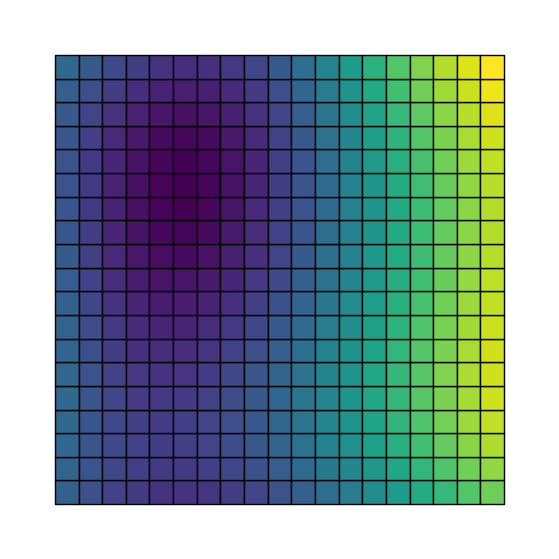

In [52]:
k = GPy.kern.RBF(input_dim=2,lengthscale=0.4)
mu = np.zeros((node_X.shape[0]))
C = k.K(node_X,node_X)
Z = np.random.multivariate_normal(mu,C,n_params)

c_elem = 0.25*(Z[0][elements[:,0]] + Z[0][elements[:,1]] + Z[0][elements[:,2]] + Z[0][elements[:,3]])
fig, ax, p = plotmesh(elements, node_X, c_elem, title=''); 
ax.axis('off')
fig.savefig('f(x)_3.png', transparent=True)

2023-07-29 20:06:09.257260: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 17m53.838154s

********************************
[Compiling module jit_scan] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-07-29 20:23:33.356818: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 17m18.334618s

********************************
[Compiling module jit_scan] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


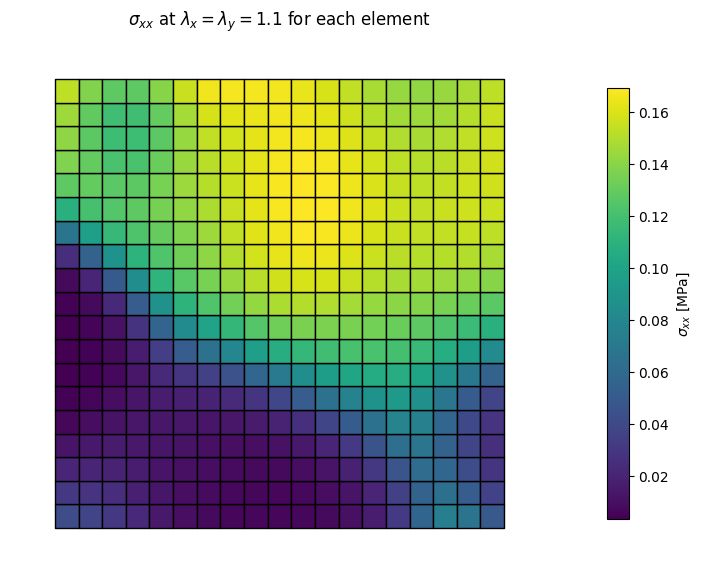

In [53]:
score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)

n_params = 31
stat = [] # statistic of interest
for initial in Z.T:
    initial = initial[None,:]
    l = reverse_sde2(rng, initial, drift, dispersion, trained_score)[0]
    l_unscaled = l*std_x+mu_x 
    sample_params = unravel_params(l_unscaled)

    params = merge_weights_aniso(params_all, sample_params)
    mymodel = NODE_model_aniso(params)
    lmbx = np.linspace(1,1.1) 
    sigx, sigy = eval_Cauchy_aniso_vmap(lmbx,lmbx, mymodel) # Equibi
    stat.append(sigx[-1])
stat = np.array(stat)

c_elem = 0.25*(stat[elements[:,0]] + stat[elements[:,1]] + stat[elements[:,2]] + stat[elements[:,3]])
fig, ax, p = plotmesh(elements, node_X, c_elem, title='$\sigma_{xx}$ at $\lambda_x=\lambda_y=1.1$ for each element'); 
fig.colorbar(p, label="$\sigma_{xx}$ [MPa]", shrink=0.8)
ax.axis('off')
fig.savefig('sigma_at_1.1_3.png', transparent=True)

This is working well, but to be extra careful we need to pass in the random noise from spatially correlated GPs

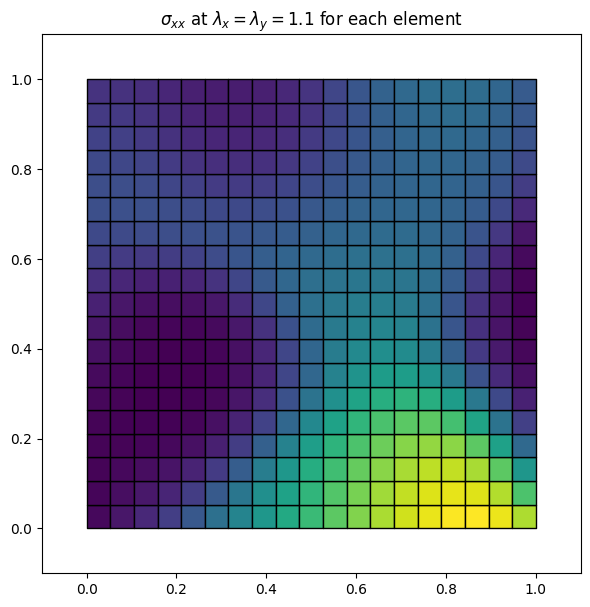

In [10]:
score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)

D = train_ts.shape[0]-1
n_params = 31
k = GPy.kern.RBF(input_dim=2,lengthscale=0.5)
mu = np.zeros((node_X.shape[0]))
C = k.K(node_X,node_X)
Z_p = np.random.multivariate_normal(mu,C,n_params).T # Random normal noise for the initial value
# Z_t = np.random.multivariate_normal(mu,C,D) # Random normal noise for each step
Z_t = []
for i in range(D):
    Z_t.append(np.random.multivariate_normal(mu,C,n_params))
Z_t = np.array(Z_t).transpose([2,0,1])

stat = []
for initial, noise in zip(Z_p, Z_t):
    initial = initial[None,:]
    l = reverse_sde3(initial, drift, dispersion, trained_score, noise)[0]
    l_unscaled = l*std_x+mu_x 
    sample_params = unravel_params(l_unscaled)

    params = merge_weights_aniso(params_all, sample_params)
    mymodel = NODE_model_aniso(params)
    lmbx = np.linspace(1,1.1) 
    sigx, sigy = eval_Cauchy_aniso_vmap(lmbx,lmbx, mymodel) # Equibi
    stat.append(sigx[-1])
stat = np.array(stat)

c_elem = 0.25*(stat[elements[:,0]] + stat[elements[:,1]] + stat[elements[:,2]] + stat[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='$\sigma_{xx}$ at $\lambda_x=\lambda_y=1.1$ for each element'); 

## Abaqus

In [10]:
# Prepare the parameters to be written
n_neurons = 5
with open('params/mice_std_x_width_' + str(n_neurons) + '.npy', 'rb') as f:
    std_x = pickle.load(f)
with open('params/mice_mu_x_width_' + str(n_neurons) + '.npy', 'rb') as f:
    mu_x = pickle.load(f)
with open('params/mice_diffusion_params_width_' + str(n_neurons) + '.npy', 'rb') as f:
    params_diff = pickle.load(f)
with open('params/mice_node_m_width_'+str(n_neurons)+'.npy', 'rb') as f:
    params_all = pickle.load(f)
with open('params/mice_node_s_width_'+str(n_neurons)+'.npy', 'rb') as f:
    Sample_params = pickle.load(f)
unravel_params = ravel_pytree(Sample_params[0])[1]

murine_data = pd.read_csv('data/murine_data.csv')
J = np.max(np.unique(murine_data.ID))

validation_params = Sample_params[-1]
validation_params = ravel_pytree(validation_params)[0]
validation_params = (validation_params-mu_x)/std_x




# Common parameters
NODE_weights, theta, Psi1_bias, Psi2_bias, alpha = params_all
params_I1, params_I2, params_1_v, params_1_w, params_v_w = NODE_weights
params_I1c,params_I1s = params_I1
params_I2c,params_I2s = params_I2
params_1_vc,params_1_vs = params_1_v
params_1_wc,params_1_ws = params_1_w
params_v_wc,params_v_ws = params_v_w

aux, unravel = ravel_pytree(params_I1)
params_Iv   = unravel(aux*0) #Just create dummy empty params lists because the current UANISOHYPER expects all of these
params_Iw   = unravel(aux*0)
params_1_2  = unravel(aux*0)
params_2_v  = unravel(aux*0)
params_2_w  = unravel(aux*0)

NODE_weights = [params_I1, params_I2, params_Iv, params_Iw, params_1_2, params_1_v, params_1_w, params_2_v, params_2_w, params_v_w]
NODE_weights = ravel_pytree(NODE_weights)[0]

n_layers = 4
n_input = 1
n_weights = 35
n_biases = 11
n_neuronsperlayer = np.array([1,5,5,1])
activtypes = np.array([3, 3, 0])
Iweights = np.array([0.0, alpha[0], alpha[1], 0.0, 0.0, alpha[2]]) # Just put 0.5 for the unused combinations
theta = theta
Psi1_bias = Psi1_bias
Psi2_bias = Psi2_bias

p = np.hstack([n_layers, n_input, n_weights, n_biases, n_neuronsperlayer, NODE_weights, activtypes, Iweights, theta, Psi1_bias, Psi2_bias])
p = np.pad(p, (0, 8-p.shape[0]%8)) # Increase p by dummy zeros so that it is divisible by 8, just so I have even columns and rows
nprops = p.shape[0] #376
p = p.reshape(-1,8)
writeableparams = ',\n'.join(', '.join('%.17f' % num for num in row) for row in p) # This properly converts p into str

In [11]:
# Read the nodes and elements
# path = 'fem/square/'
# fname = 'square_equi'
# path = 'fem/PurdueP/'
# fname = 'PP_fine_comp'
path = 'fem/PurdueP/'
fname = 'PP_fine_filleted'
file = path + fname + '.inp'
with open(file) as f:
    lines = [line.rstrip('\n') for line in f]

# Get the elements (only needed for plotting the mesh)
i1 = -1
i2 = -1
for i, line in enumerate(lines):
    if line.find('*Element') >= 0:
        # get the element type
        j = line.find('=')
        elemtype = line[j+1:]
        i1 = i+1
        break


for j, line in enumerate(lines[i1:]):
    if line.find('*') >= 0:
        i2 = i1+j
        break
elems = lines[i1:i2]
elems = [line.split() for line in elems]
elems = [[a.rstrip(',') for a in line] for line in elems]
elems = np.array(elems, dtype=int)
elems = elems[:,1:]


# Get the nodes (needed for generating the Gaussian Fields, and for plotting)
i1 = -1
i2 = -1
for i, line in enumerate(lines): # Find the line that starts with '*Node'
    if line.find('*Node') >= 0:
        i1 = i+1
        break
for i, line in enumerate(lines): # Find the line that starts with '*Element' 
    if line.find('*Element') >= 0:
        i2 = i
        break
lines = lines[i1:i2]
lines = [line.split() for line in lines]
lines = [[a.rstrip(',') for a in line] for line in lines]
node_X = np.array(lines, dtype=float)
nodes = np.array(node_X[:,0],dtype=int)
node_X = node_X[:,1:3]
node_X = np.hstack([node_X, np.zeros(len(node_X))[:,None]]) # Add a z coordinate

In [7]:
score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)
mod_score = lambda x, t, sgm_msr: trained_score(x,t) - (x-validation_params)/sgm_msr**2
n_params = 31

m = Mesh(verts = node_X, connectivity = elems-1)
K, M = m.computeLaplacian()
M *= 2 # bug in mass matrix
eigvals, eigvecs = eigh(K,M)
n_eigs = m.verts.shape[0]
eigpairs = (np.array(eigvals[:n_eigs]), np.array(eigvecs[:,:n_eigs]).T)
D = 1
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
bounds = {'lb': lb, 'ub': ub}
p_x = uniform_prior(lb, np.ones(D)*m.verts.shape[0])
d = 3/2 + 0.5 * 2
options = {'kernel': 'RBF',
           'criterion': 'LW_CLSF',
           'input_prior': p_x,
           'kappa': 1.0,
           'nIter': 0}
mcmc_settings = {'num_warmup': 500,
                 'num_samples': 500,
                 'num_chains': 1,
                 'target_accept_prob': 0.9}
gp_model = ReimannianGPclassifierFourier(options, eigpairs)


for sgmmsr in [0.04, 0.06, 0.08]:
    print('sgmmsr: ', sgmmsr)
    mod_score_2 = lambda x, t: mod_score(x,t,sgmmsr) 
    for lenscale2 in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        lenscale = np.round(lenscale2*np.max(node_X),1)
        print('lenscale: ', lenscale2)
        # S = gp_model.eval_S(lenscale, 1.0)
        S = np.power(lenscale, 2*d) * \
            np.power(1. + np.power(lenscale, 2)*gp_model.eigenvalues, -d)
        for init in range(1,11):
            print('init: ', init)
            rng, _ = random.split(rng)
            ws = random.normal(rng, shape = (n_eigs,train_ts.shape[0]*n_params))
            norm_const = np.average((S[None,:]*gp_model.eigenfunctions**2).sum(1))
            f = np.dot(gp_model.eigenfunctions,ws*np.sqrt(S)[:,None])
            f /= np.sqrt(norm_const)
            f = f.reshape(m.verts.shape[0], -1, 31)

            Z_p = f[:,0,:]
            Z_t = f[:,1:,:]

            Sample_params = []
            for i, (initial, noise) in enumerate(zip(Z_p, Z_t)):
                initial = initial[None,:]
                l = reverse_sde3(initial, drift, dispersion, mod_score_2, noise)[0]
                l_unscaled = l*std_x+mu_x 
                Sample_params.append(l_unscaled)
            
            

            # Write the common parts of the Abaqus input file
            # for fname in ['square_equi', 'square_offx', 'square_offy']:
            #     file = path + fname + '.inp'
            with open(file, 'r') as f:
                inptxt = f.read()

            # Inject the header
            i1 = inptxt.find('*Anisotropic Hyperelastic')
            i2 = i1 + inptxt[i1:].find('\n')
            header = '*Anisotropic Hyperelastic, user, formulation=INVARIANT, type=INCOMPRESSIBLE, local direction=2, properties=' \
                + str(nprops) + ', moduli=INSTANTANEOUS'
            inptxt = inptxt[:i1] + header + inptxt[i2:]

            i = inptxt.find('*Anisotropic Hyperelastic')
            i1 = i + inptxt[i:].find('\n') + 1
            i2 = i + inptxt[i:].find('**')

            inptxt = inptxt[:i1] + writeableparams + '\n' + inptxt[i2:]
            

            # Write the heterogeneous parts of the Abaqus input file
            # Find the instance name
            i1 = inptxt.find('*Instance')
            i1 = i1 + inptxt[i1:].find('=') + 1
            i2 = i1 + inptxt[i1:].find(',')
            instname = inptxt[i1:i2]

            # Define node sets for each node
            i = inptxt.find('*Assembly')
            i = i + inptxt[i:].find('*Nset')
            part1, part2 = inptxt[:i], inptxt[i:]
            for node in nodes:
                part1 += "*Nset, nset=myset-" + str(node) + ", instance=" + instname + " \n " + str(node) + ",\n"
            inptxt = part1+part2

            # Define field variables for each node set
            i = inptxt.find("** ----")
            part1, part2 = inptxt[:i], inptxt[i:]
            part1 += "** \n** PREDEFINED FIELDS\n** \n"
            k = 1
            for i in range(len(nodes)):
                node = nodes[i]
                for j, param in enumerate(Sample_params[i]):
                    part1 += "** Name: myfield-" + str(k) + "   Type: Field\n*Initial Conditions, type=FIELD, variable=" + \
                        str(j+1) + "\nmyset-" + str(node) + ", " + str(param) + "\n"
                    k+= 1
            inptxt = part1+part2

            outfile = path + fname + '_sgmmsr_{}_lenscale_{}_init_{}.inp'.format(sgmmsr, lenscale2, int(init))
            with open(outfile, 'w') as f:
                f.write(inptxt)
            
            outfile = path + fname + '_sgmmsr_{}_lenscale_{}_init_{}_sample_params.txt'.format(sgmmsr, lenscale2, int(init))
            with open(outfile, 'wb') as f:
                pickle.dump(Sample_params, f)

sgmmsr:  0.04
lenscale:  0.05
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8


2023-08-15 23:11:47.538287: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 15m22.930942s

********************************
[Compiling module jit_scan] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-08-15 23:28:01.532042: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 15m49.754173s

********************************
[Compiling module jit_scan] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-08-15 23:38:41.982369: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m35.434115s

********************************
[Compiling module jit_scan] Very slow compile?  If you want to file a bug, run with envvar X

init:  9
init:  10
lenscale:  0.1
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8
init:  9
init:  10
lenscale:  0.2
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8
init:  9
init:  10
lenscale:  0.3
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8
init:  9
init:  10
lenscale:  0.4
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8
init:  9
init:  10
lenscale:  0.5
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8
init:  9
init:  10
lenscale:  0.6
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8
init:  9
init:  10
sgmmsr:  0.06
lenscale:  0.05
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8
init:  9
init:  10
lenscale:  0.1
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8
init:  9
init:  10
lenscale:  0.2
init:  1
init:  2
init:  3
init:  4
init:  5
init:  6
init:  7
init:  8
init:  9
init:  10
lenscale:  0

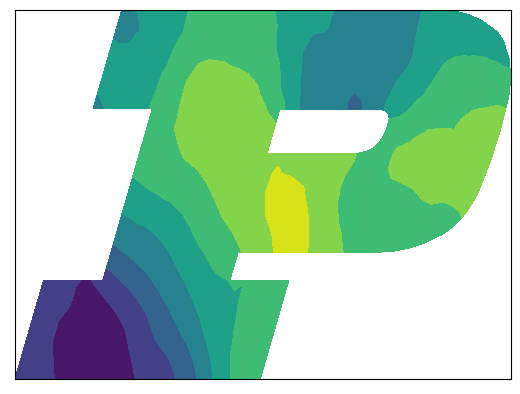

In [129]:
plt.xticks([])
plt.yticks([])
plt.tricontourf(m.verts[:,0], m.verts[:,1], m.connectivity, Z_t[:,0,4])

### Write 3 homogeneous files

In [12]:
# Generate a bunch of samples so that you can pick a stiff, soft and medium one
sgmmsr = 0.08
score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)
mod_score = lambda x, t, sgm_msr: trained_score(x,t) - (x-validation_params)/sgm_msr**2
mod_score_2 = lambda x, t: mod_score(x,t,sgmmsr) 
rng, _ = random.split(rng)
samples = reverse_sde(rng, n_params, 100, drift, dispersion, mod_score_2)

aux = []
for l in samples:
    l_unscaled = l*std_x+mu_x 
    sample_params = unravel_params(l_unscaled)
    params = merge_weights_aniso(params_all, sample_params)
    mymodel = NODE_model_aniso(params)
    lmbx = np.linspace(1,1.25) 
    sigx,sigy = eval_Cauchy_aniso_vmap(lmbx,lmbx, mymodel) # Equibi
    aux.append(sigx[-1])
i_stiff = np.argmax(aux)
i_soft = np.argmin(aux)
i_med = np.argmin(np.abs(aux-np.median(aux, axis=0)))

for label, ii in zip(['soft', 'med', 'stiff', 'baseline'], [i_soft, i_med, i_stiff, i_stiff]):
    file = path + fname + '.inp'
    with open(file, 'r') as f:
        inptxt = f.read()

    # Inject the header
    i1 = inptxt.find('*Anisotropic Hyperelastic')
    i2 = i1 + inptxt[i1:].find('\n')
    header = '*Anisotropic Hyperelastic, user, formulation=INVARIANT, type=INCOMPRESSIBLE, local direction=2, properties=' \
        + str(nprops) + ', moduli=INSTANTANEOUS'
    inptxt = inptxt[:i1] + header + inptxt[i2:]

    i = inptxt.find('*Anisotropic Hyperelastic')
    i1 = i + inptxt[i:].find('\n') + 1
    i2 = i + inptxt[i:].find('**')

    inptxt = inptxt[:i1] + writeableparams + '\n' + inptxt[i2:]
    

    # Write the heterogeneous parts of the Abaqus input file
    # Find the instance name
    i1 = inptxt.find('*Instance')
    i1 = i1 + inptxt[i1:].find('=') + 1
    i2 = i1 + inptxt[i1:].find(',')
    instname = inptxt[i1:i2]

    # Define node sets for each node
    i = inptxt.find('*Assembly')
    i = i + inptxt[i:].find('*Nset')
    part1, part2 = inptxt[:i], inptxt[i:]
    for node in nodes:
        part1 += "*Nset, nset=myset-" + str(node) + ", instance=" + instname + " \n " + str(node) + ",\n"
    inptxt = part1+part2

    # Define field variables for each node set
    i = inptxt.find("** ----")
    part1, part2 = inptxt[:i], inptxt[i:]
    part1 += "** \n** PREDEFINED FIELDS\n** \n"
    k = 1
    sample_params = samples[ii]*std_x + mu_x
    if label=='baseline':
        sample_params = validation_params*std_x + mu_x
        
    for i in range(len(nodes)):
        node = nodes[i]
        for j, param in enumerate(sample_params):
            part1 += "** Name: myfield-" + str(k) + "   Type: Field\n*Initial Conditions, type=FIELD, variable=" + \
                str(j+1) + "\nmyset-" + str(node) + ", " + str(param) + "\n"
            k+= 1
    inptxt = part1+part2

    outfile = path + fname + '_homogeneous_' + label + '.inp'
    with open(outfile, 'w') as f:
        f.write(inptxt)

#### Check outputs of Abaqus

In [81]:
# sample_params = np.array(Sample_params)[elems[288]-1].mean(axis=0)
params = merge_weights_aniso(params_all, unravel_params(sample_params))
NODE_weights, theta, Psi1_bias, Psi2_bias, alpha = params
params_I1, params_I2, params_1_v, params_1_w, params_v_w = NODE_weights


def Psi1(I1, Iv, Iw):
    I1 = I1-3.0
    Iv = Iv-1.0
    Iw = Iw-1.0
    Psi1 = NODE(I1, params_I1)
    a1 = jax.nn.sigmoid(alpha[0])
    Psiv_1 = NODE(a1*I1 + (1.0-a1)*Iv, params_1_v)
    Psiv_1 = jnp.maximum(Psiv_1, 0.0)
    a2 = jax.nn.sigmoid(alpha[1])
    Psiw_1 = NODE(a2*I1 + (1.0-a2)*Iw, params_1_w)
    Psiw_1 = jnp.maximum(Psiw_1, 0.0)
    return Psi1, Psiv_1, Psiw_1, Psi1 + Psiv_1*a1 + Psiw_1*a2 + jnp.exp(Psi1_bias)
def Psi2(I2):
    I2 = I2-3.0
    Psi2 = NODE(I2, params_I2)
    return Psi2, Psi2 + jnp.exp(Psi2_bias)
def Psiv(I1, Iv, Iw):
    I1 = I1-3.0
    Iv = Iv-1.0
    Iw = Iw-1.0
    a1 = jax.nn.sigmoid(alpha[0])
    Psi1_v = NODE(a1*I1 + (1.0-a1)*Iv, params_1_v)
    Psi1_v = jnp.maximum(Psi1_v, 0.0)
    a2 = jax.nn.sigmoid(alpha[2])
    Psiw_v = NODE(a2*Iv + (1.0-a2)*Iw, params_v_w)
    Psiw_v = jnp.maximum(Psiw_v, 0.0)
    return Psi1_v, Psiw_v, Psi1_v*(1.0-a1) + Psiw_v*a2
def Psiw(I1, Iv, Iw):
    I1 = I1-3.0
    Iv = Iv-1.0
    Iw = Iw-1.0
    a1 = jax.nn.sigmoid(alpha[1])
    Psi1_w = NODE(a1*I1 + (1.0-a1)*Iw, params_1_w)
    Psi1_w = jnp.maximum(Psi1_w, 0.0)
    a2 = jax.nn.sigmoid(alpha[2])
    Psiv_w = NODE(a2*Iv + (1.0-a2)*Iw, params_v_w)
    Psiv_w = jnp.maximum(Psiv_w, 0.0)
    return Psi1_w, Psiv_w, Psi1_w*(1.0-a1) + Psiv_w*(1.0-a2)
def inputs(I1, I2, Iv, Iw):
    I1 = I1-3.0
    I2 = I2-3.0
    Iv = Iv-1.0
    Iw = Iw-1.0
    a2 = jax.nn.sigmoid(alpha[0])
    a3 = jax.nn.sigmoid(alpha[1])
    a6 = jax.nn.sigmoid(alpha[2])
    J1 = 0.0
    J2 = a2*I1 + (1.0-a2)*Iv
    J3 = a3*I1 + (1.0-a3)*Iw
    J4 = 0.0
    J5 = 0.0
    J6 = a6*Iv + (1.0-a6)*Iw
    return I1, I2, Iv, Iw, J1, J2, J3, J4, J5, J6

I1 = 3.32445513149279
I2 = 3.39305489295749
Iv = 1.56250000000000 
Iw = 1.24992400000000

print('Inputs of NODEs')
print(*inputs(I1, I2, Iv, Iw))
print('theta')
print(theta)
print('Psi1_bias, Psi2_bias')
print(Psi1_bias, Psi2_bias)
print('alpha weights after sigmoiding')
print(jax.nn.sigmoid(0.0), jax.nn.sigmoid(alpha[0]), jax.nn.sigmoid(alpha[1]), jax.nn.sigmoid(0.0), jax.nn.sigmoid(0.0), jax.nn.sigmoid(alpha[2]))
print('Weights of NODEs')
print('params_I1')
print(params_I1)
print('params_I2')
print(params_I2)
print('params_Iv')
print(params_Iv)
print('params_Iw')
print(params_Iw)
print('params_J1')
print(0.0)
print('params_J2')
print(params_1_v)
print('params_J3')
print(params_1_w)
print('params_J4')
print(0.0)
print('params_J5')
print(0.0)
print('params_J6')
print(params_v_w)
print('Outputs of NODEs')
print('Psi1')
print(Psi1(I1,Iv,Iw)[0])
print('Psi2')
print(Psi2(I2)[0])
print('Psiv')
print(0.0)
print('Psiw')
print(0.0)
print('Phi1')
print(0.0)
print('Phi2')
print(Psi1(I1,Iv,Iw)[1])
print('Phi3')
print(Psi1(I1,Iv,Iw)[2])
print('Phi4')
print(0.0)
print('Phi5')
print(0.0)
print('Phi6')
print(Psiv(I1,Iv,Iw)[1])
print('Final derivatives of strain energy to be returned to Abaqus:')
model = NODE_model_aniso(params)
print('Psi1 final, Psi2 final, Psiv final, Psiw final')
print(model.Psi1(I1,I2,Iv,Iw),model.Psi2(I1,I2,Iv,Iw),model.Psiv(I1,I2,Iv,Iw),model.Psiw(I1,I2,Iv,Iw))
print('Final 2nd derivatives of strain energy to be returned to Abaqus:')
print('Psi11, Psi22, Psivv, Psiww, Psi12, Psi1v, Psi1w, Psi2v, Psi2w, Psivw')
print(grad(model.Psi1, argnums=0)(I1,I2,Iv,Iw), 
      grad(model.Psi2, argnums=1)(I1,I2,Iv,Iw),
      grad(model.Psiv, argnums=2)(I1,I2,Iv,Iw),
      grad(model.Psiw, argnums=3)(I1,I2,Iv,Iw),
      grad(model.Psi1, argnums=1)(I1,I2,Iv,Iw),
      grad(model.Psi1, argnums=2)(I1,I2,Iv,Iw),
      grad(model.Psi1, argnums=3)(I1,I2,Iv,Iw),
      grad(model.Psi2, argnums=2)(I1,I2,Iv,Iw),
      grad(model.Psi2, argnums=3)(I1,I2,Iv,Iw),
      grad(model.Psiv, argnums=3)(I1,I2,Iv,Iw))
print('2nd Derivatives numerically')
eps = 1.0e-10
print((model.Psi1(I1+eps,I2,Iv,Iw) - model.Psi1(I1-eps,I2,Iv,Iw))/2/eps,
      (model.Psi2(I1,I2+eps,Iv,Iw) - model.Psi2(I1,I2-eps,Iv,Iw))/2/eps,
      (model.Psiv(I1,I2,Iv+eps,Iw) - model.Psiv(I1,I2,Iv-eps,Iw))/2/eps,
      (model.Psiw(I1,I2,Iv,Iw+eps) - model.Psiw(I1,I2,Iv,Iw-eps))/2/eps,
      (model.Psi1(I1,I2+eps,Iv,Iw) - model.Psi1(I1,I2-eps,Iv,Iw))/2/eps,
      (model.Psi1(I1,I2,Iv+eps,Iw) - model.Psi1(I1,I2,Iv-eps,Iw))/2/eps,
      (model.Psi1(I1,I2,Iv,Iw+eps) - model.Psi1(I1,I2,Iv,Iw-eps))/2/eps,
      (model.Psi2(I1,I2,Iv+eps,Iw) - model.Psi2(I1,I2,Iv-eps,Iw))/2/eps,
      (model.Psi2(I1,I2,Iv,Iw+eps) - model.Psi2(I1,I2,Iv,Iw+eps))/2/eps,
      (model.Psiv(I1,I2,Iv,Iw+eps) - model.Psiv(I1,I2,Iv,Iw-eps))/2/eps,)




# Calculate the stress for these derivatives
lmbx = 1.25
lmby = np.sqrt(lmbx)
lmbz = 1.0/(lmbx*lmby)
F = jnp.array([[lmbx, 0, 0],
                [0, lmby, 0],
                [0, 0, lmbz]])
C = F.T @ F
C2 = C @ C
Cinv = jnp.linalg.inv(C)
theta = 0.0
v0 = jnp.array([ jnp.cos(theta), jnp.sin(theta), 0])
w0 = jnp.array([-jnp.sin(theta), jnp.cos(theta), 0])
V0 = jnp.outer(v0, v0)
W0 = jnp.outer(w0, w0)

I1 = C[0,0] + C[1,1] + C[2,2]
trC2 = C2[0,0] + C2[1,1] + C2[2,2]
I2 = 0.5*(I1**2 - trC2)
Iv = jnp.einsum('ij,ij',C,V0)
Iw = jnp.einsum('ij,ij',C,W0)

Psi1 = model.Psi1(I1, I2, Iv, Iw)
Psi2 = model.Psi2(I1, I2, Iv, Iw)
Psiv = model.Psiv(I1, I2, Iv, Iw)
Psiw = model.Psiw(I1, I2, Iv, Iw)

p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2] + 2*Psiw*W0[2,2])
S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0 + 2*Psiw*W0

print('Recalculated invariants for OffY')
print(I1, I2, Iv, Iw) 

sgm = F @ (S @ F.T)
print('Predicted stress')
print(sgm[0,0], sgm[1,1])

Inputs of NODEs
0.3244551314927899 0.39305489295748997 0.5625 0.24992400000000004 0.0 0.4869823373800303 0.26846231826997746 0.0 0.0 0.5623840442959693
theta
-1.5707963267948966
Psi1_bias, Psi2_bias
-13.778958098579947 -14.630934929947216
alpha weights after sigmoiding
0.5 0.3172412961201153 0.24873254838175649 0.5 0.5 0.9996290319665276
Weights of NODEs
params_I1
([Array([[-2.1204269 ,  0.80639856, -1.16802199,  0.70357006,  0.12301107]],      dtype=float64), Array([[-0.10087181, -1.44262789, -0.66619115, -1.17911674,  0.52302725],
       [ 0.55714135,  2.1356653 ,  1.39759295,  2.45742184, -0.0951249 ],
       [ 0.46496915, -1.20498914,  0.31882821, -1.8213122 , -0.23562746],
       [ 0.1083618 ,  1.64853296,  1.04090975,  1.63762518, -0.43041116],
       [-0.3012295 ,  0.52253568, -0.04093181,  0.36399982,  0.30328715]],      dtype=float64)], [Array([[-0.03198257],
       [-1.14395846],
       [-1.30049709],
       [-0.77853833],
       [ 0.14864214]], dtype=float64)])
params_I2
([A